In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [3]:
def plot(df):
    df = (df-df.min())/(df.max()-df.min())
    return px.line(df)

<Axes: >

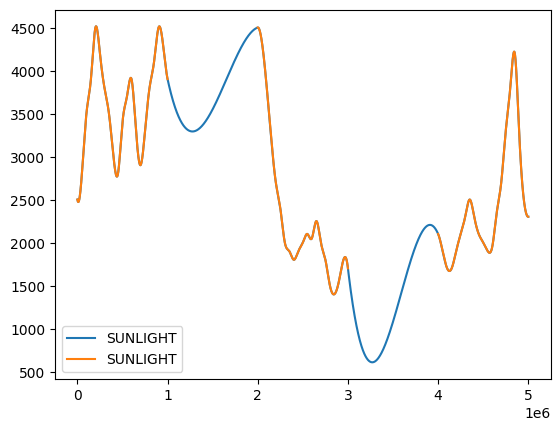

In [2]:
data = pd.concat([pd.read_csv(f'data/round_2/prices_round_2_day_{i}.csv', sep=';') for i in [-1,0,1]])
data["timestamp"] = data["timestamp"]+data["DAY"]*1000000*2
data["timestamp"] -= data["timestamp"].min()
data.drop("DAY", axis=1, inplace=True)
data.set_index("timestamp", inplace=True,drop=True)
data = data.reindex(pd.Index(range(data.index.min(),data.index.max(),100)))
data_i = data.interpolate(method="cubicspline")
key = "SUNLIGHT"
pd.concat([data_i[key], data[key]], axis=1).plot()

In [4]:
px.line(data["SUNLIGHT"])

In [5]:
production = 100 - ((data["HUMIDITY"] - 70).abs()-10).clip(0)*2/5

In [6]:
px.line(production)

In [29]:
from xgboost import XGBClassifier

In [30]:
X = data.shift()
X = pd.concat([X, X.rolling(30).mean().add_suffix("_30_mean"),X.rolling(30).median().add_suffix("_30_med"), production.rename("production")], axis=1)
y = data["ORCHIDS"].pct_change()>0
y = y[y.index.isin(X.index)].dropna()
X = X[X.index.isin(y.index)]

/var/folders/9t/dzjfbkxs0dlfrgdkycq16mnc0000gn/T/ipykernel_6150/3046483128.py:3: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [31]:
X_train = X.loc[:4000000]
X_test = X[~X.index.isin(X_train.index)]
y_train = y[y.index.isin(X_train.index)]
y_test = y[y.index.isin(X_test.index)]

In [46]:
model = XGBClassifier(n_estimators=10000, learning_rate=0.005)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
y_pred = pd.Series(model.predict(X_test),index=y_test.index)

In [41]:
from sklearn.metrics import accuracy_score, f1_score

In [49]:
accuracy_score(y_pred, y_test)

0.5788578857885789

In [39]:
px.scatter(pd.concat([y_pred, y_test*1], axis=1))

In [67]:
px.line(y_test.rolling(2000).mean()/y_test)

## Volume distribution

In [1]:
import numpy as np

from statistics import NormalDist
def f(x, mean, sigma):
    dist = NormalDist(0,1)
    return dist.cdf((x-mean+1)/sigma) - dist.cdf((x-mean)/sigma)

In [2]:
def compute_orders_sell(symbol,min_bid:int, volume:int, sigma=0.05)->list:
    remaining_volume = volume
    orders = []
    for i in range(0, 1000):
        bid = min_bid + i 
        amount = int(np.ceil(volume*2*f(bid, min_bid,sigma)))
        if amount==0 and remaining_volume>0:
            if remaining_volume>1:
                print((sigma,min_bid,volume, remaining_volume),"BIIIGG")
            amount=remaining_volume
        amount = np.minimum(amount,remaining_volume)
        remaining_volume-=amount
        orders.append((int(bid),int(-amount)))
        if remaining_volume<0:
            print((sigma,min_bid,volume),"NEGATIVE")
        if remaining_volume==0:
            break
    if remaining_volume>0:
        print((sigma,min_bid,volume),"Remaining")
    return orders

In [139]:
import pandas as pd
import plotly_express as px
px.scatter(pd.DataFrame(compute_orders_sell("ORCHIDS",10000,100,1), columns=["Bid","Volume"]).abs(), x="Bid",y="Volume")

In [3]:
for i in range(10):
    sigma = np.random.uniform(0.0000001,10)
    min_bid = np.round(np.random.uniform(0,10000))
    volume = np.round(np.random.uniform(0,1000))
    print(run(sigma, min_bid,volume))

NameError: name 'run' is not defined